Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

### Setup

#### If you're using [Anaconda](https://www.anaconda.com/distribution/) locally

Install required Python packages, if you haven't already:
- [category_encoders](http://contrib.scikit-learn.org/categorical-encoding/), version >= 2.0
- [Plotly](https://plot.ly/python/getting-started/), version >= 4.0

```
conda install -c conda-forge category_encoders plotly
```

In [69]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

# Let's start with example solutions for yesterday's assignment!

First, load data & remove outliers:

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

## Do train/test split
- Use data from April & May 2016 to train
- Use data from June 2016 to test

In [72]:
# Convert to datetime and look at the date range
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
df['created'].describe()

count                   48817
unique                  48148
top       2016-05-14 01:11:03
freq                        3
first     2016-04-01 22:12:41
last      2016-06-29 21:41:47
Name: created, dtype: object

In [73]:
# There are 16217 + 15627 observations in April & May 2016,
# and 16973 observations in June 2016.
df['created'].dt.month.value_counts()

6    16973
4    16217
5    15627
Name: created, dtype: int64

In [74]:
# There are many ways to do train/test split based on date.
# Here's one way:
train = df[df.created.dt.month < 6]
test  = df[df.created.dt.month == 6]
train.shape, test.shape

((31844, 34), (16973, 34))

In [75]:
# Here's another way
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]
train.shape, test.shape

((31844, 34), (16973, 34))

In [76]:
# Here's another way
df = df.set_index('created')
train = df[:'2016-05'].reset_index()
test  = df['2016-06':].reset_index()
df = df.reset_index()
train.shape, test.shape

((31844, 34), (16973, 34))

## Location, Location, Location?

In [77]:
# Look at relationship between location & price
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='price')

In [78]:
# Cluster the locations
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, n_jobs=-1)
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
test['cluster'] = kmeans.predict(test[['longitude', 'latitude']])
px.scatter(train, x='longitude', y='latitude', color='cluster')

In [79]:

train.groupby('bedrooms').price.mean()

bedrooms
0    2480.870706
1    3057.281467
2    3787.781992
3    4974.523553
4    5922.475355
5    8177.637681
6    8228.863636
7    6923.000000
Name: price, dtype: float64

In [80]:
train.groupby('cluster').price.mean()

cluster
0    3381.385138
1    3931.238164
2    4062.407479
3    2036.692161
4    2313.020804
5    2218.366553
6    3737.288629
7    2774.162630
8    3660.734285
9    3682.072270
Name: price, dtype: float64

In [81]:
train.groupby('cluster').price.describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,5598.0,3381.385138,2060.558603,1400.0,2200.0,2750.0,3650.0,15000.0
1,3443.0,3931.238164,1680.839423,1450.0,2870.0,3475.0,4405.0,15000.0
2,6712.0,4062.407479,1723.991295,1500.0,2895.0,3650.0,4800.0,15500.0
3,523.0,2036.692161,511.976497,1375.0,1695.0,1900.0,2250.0,4350.0
4,721.0,2313.020804,805.724926,1375.0,1800.0,2100.0,2600.0,11000.0
5,1465.0,2218.366553,665.297019,1375.0,1700.0,2000.0,2525.0,5000.0
6,5048.0,3737.288629,1705.407819,1450.0,2700.0,3300.0,4200.0,15500.0
7,1445.0,2774.162630,935.640956,1375.0,2199.0,2600.0,3186.0,14500.0
8,4343.0,3660.734285,1519.902468,1550.0,2650.0,3295.0,4288.5,15000.0


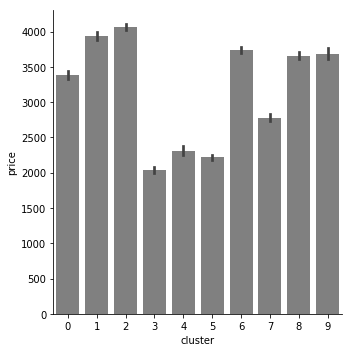

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.catplot(x='cluster', y='price', data=train, kind='bar', color='grey')

In [83]:
train['bathrooms'].value_counts()

1.0     25507
2.0      5001
3.0       455
1.5       411
0.0       191
2.5       181
4.0        62
3.5        28
4.5         5
5.0         2
10.0        1
Name: bathrooms, dtype: int64

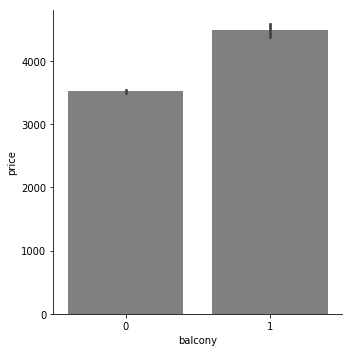

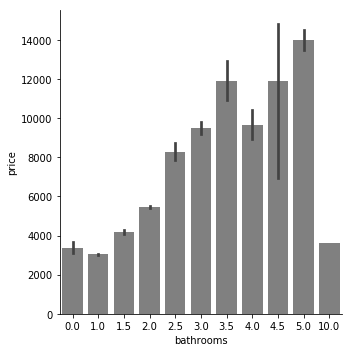

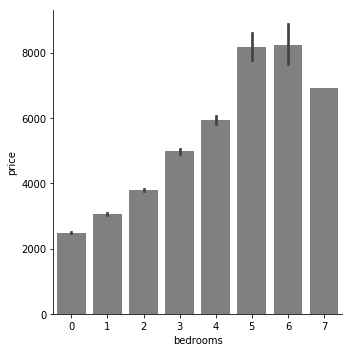

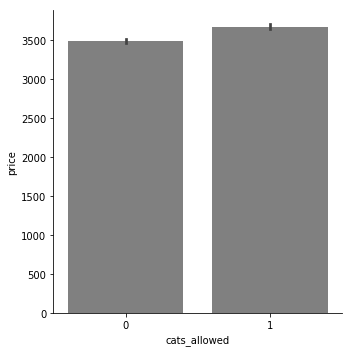

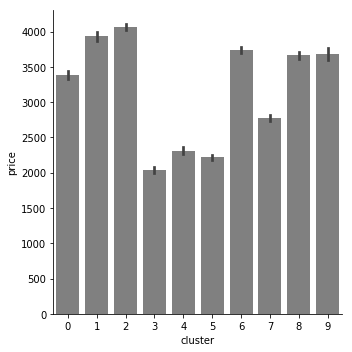

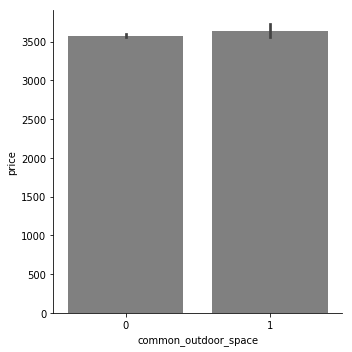

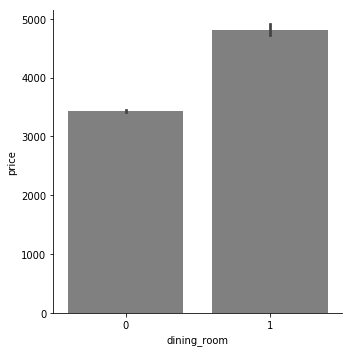

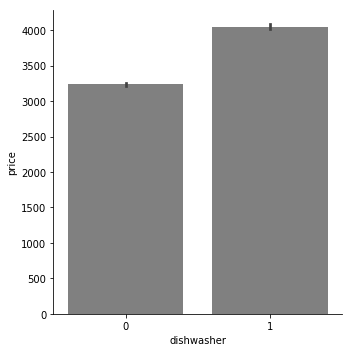

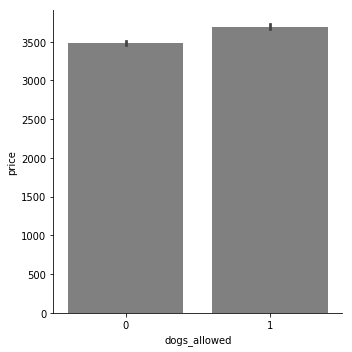

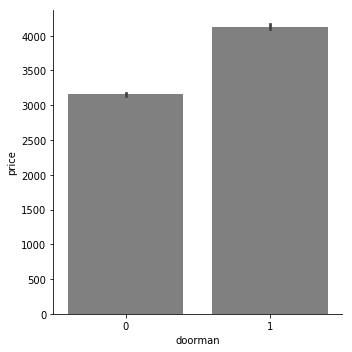

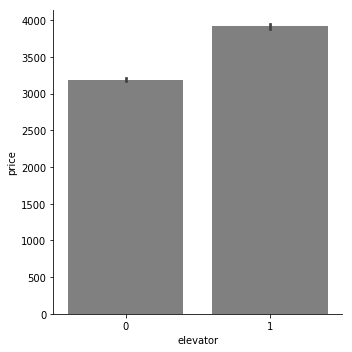

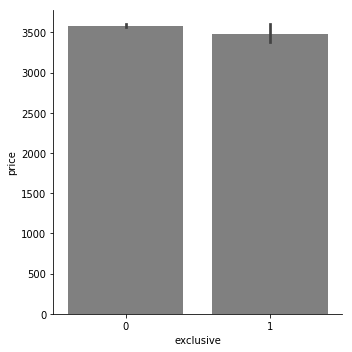

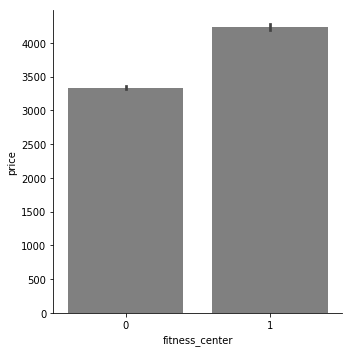

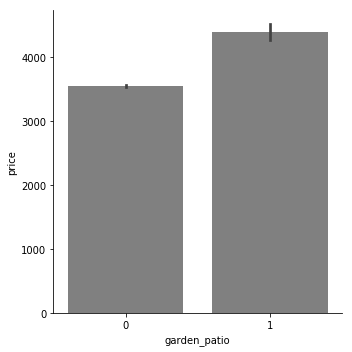

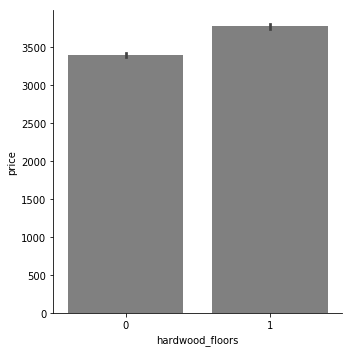

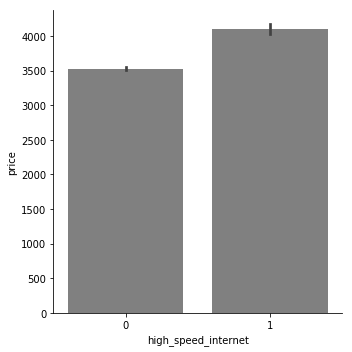

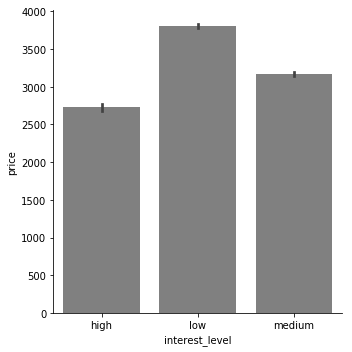

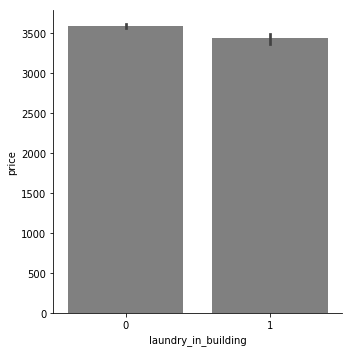

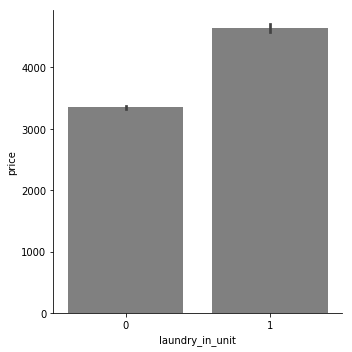

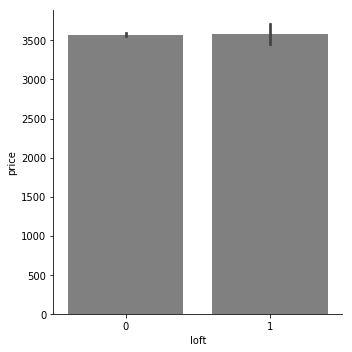

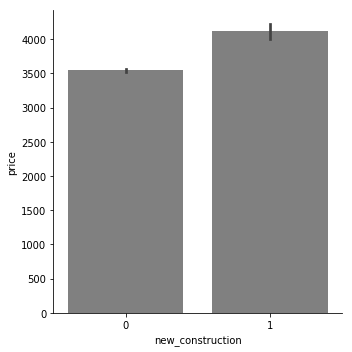

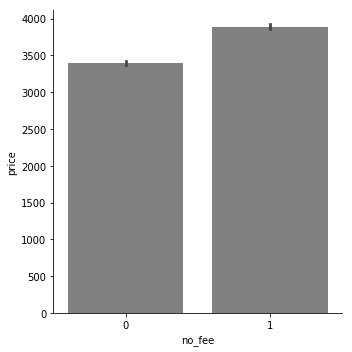

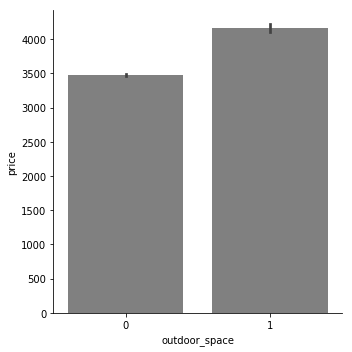

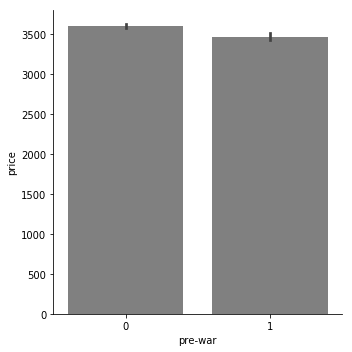

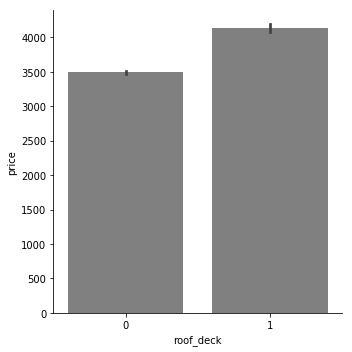

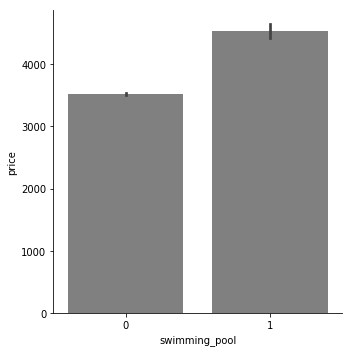

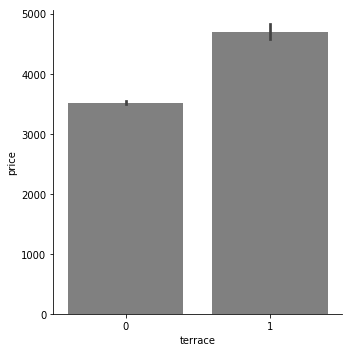

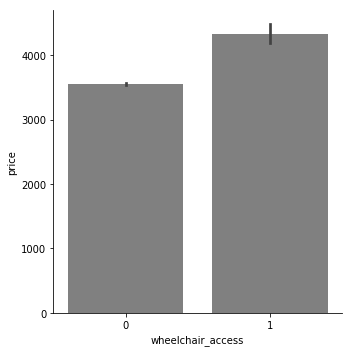

In [84]:
for col in sorted(train.columns):
  if train[col].nunique() < 12:
    sns.catplot(x=col, y='price', data=train, kind='bar', color='grey')
    plt.show()
    

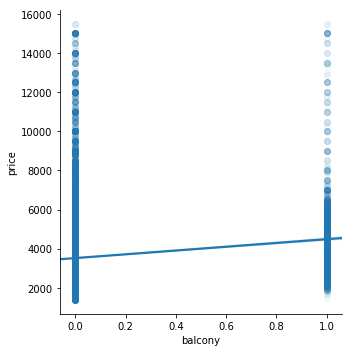

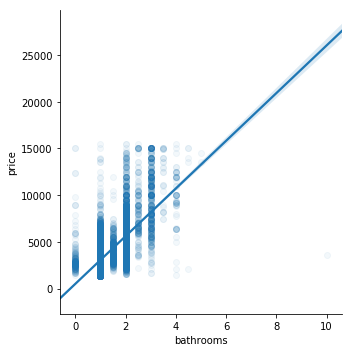

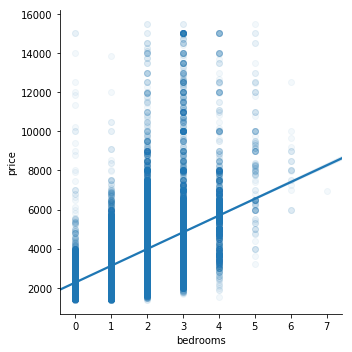

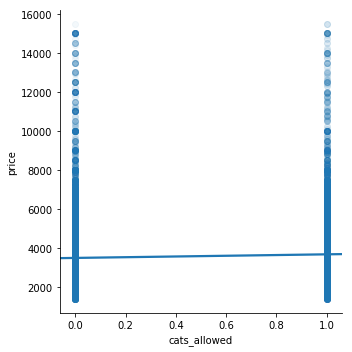

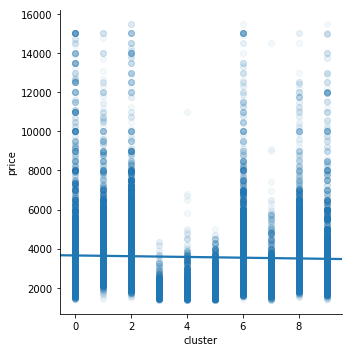

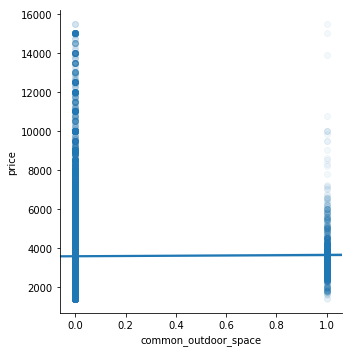

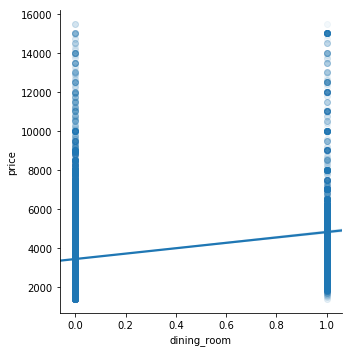

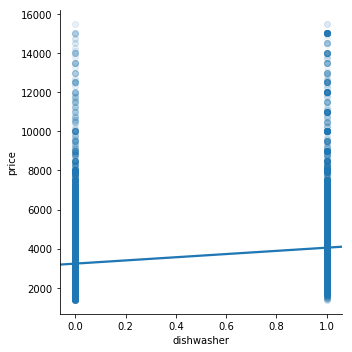

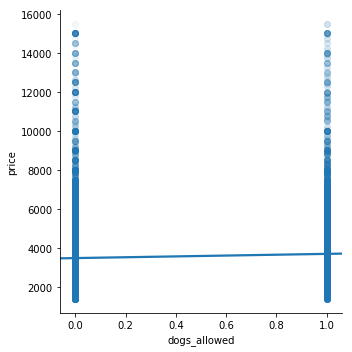

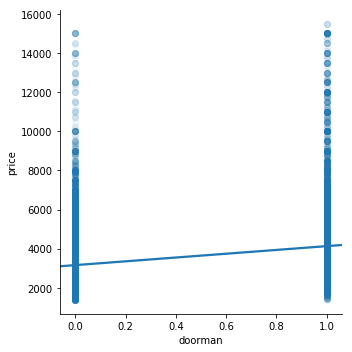

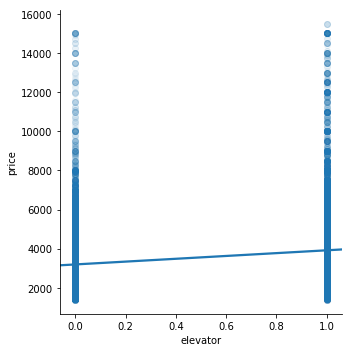

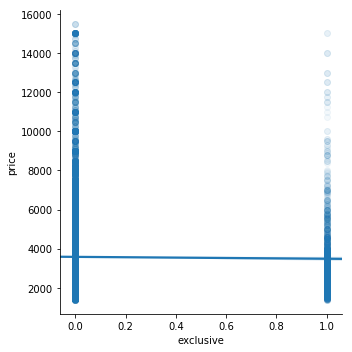

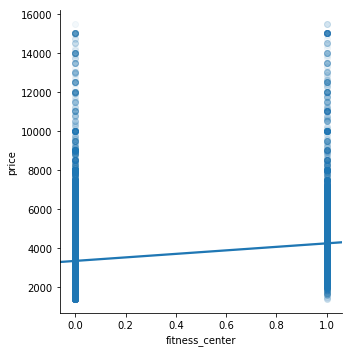

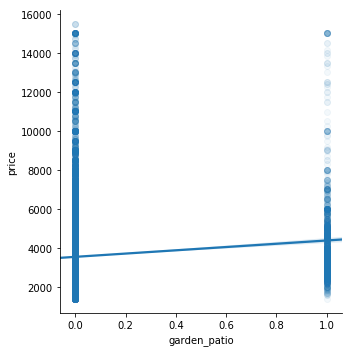

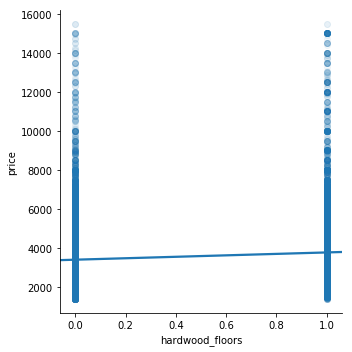

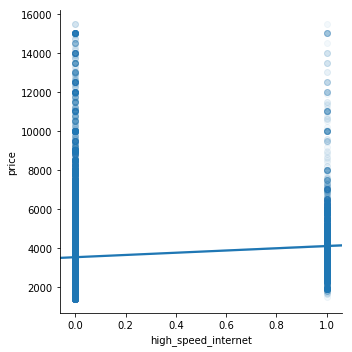

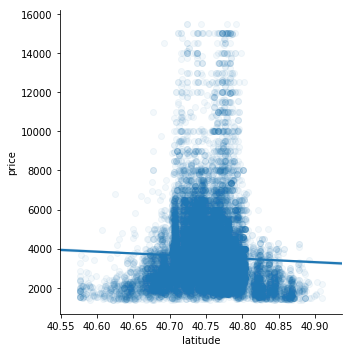

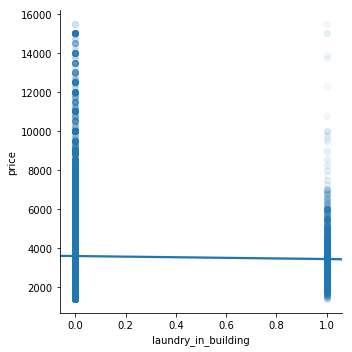

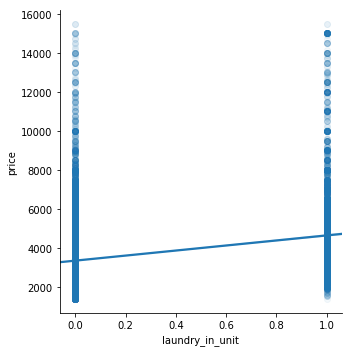

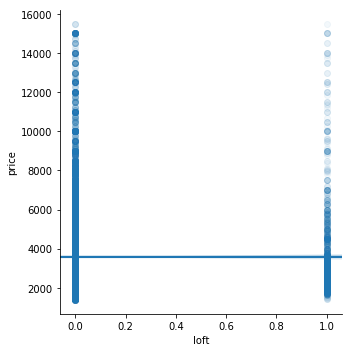

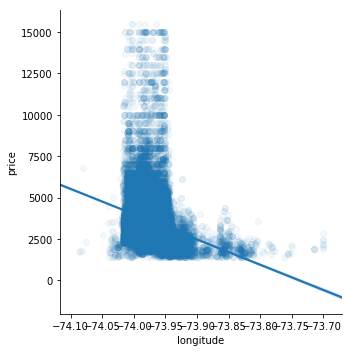

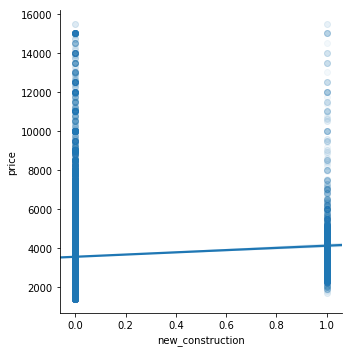

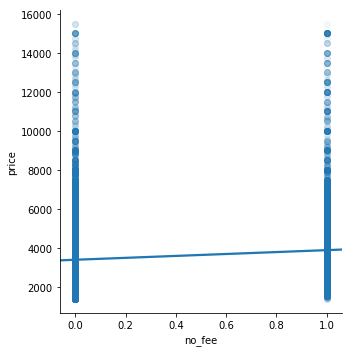

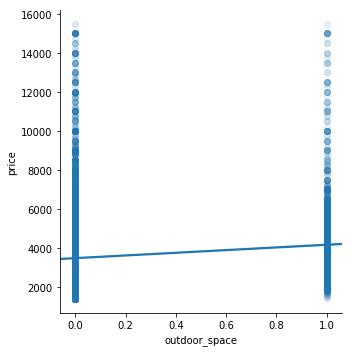

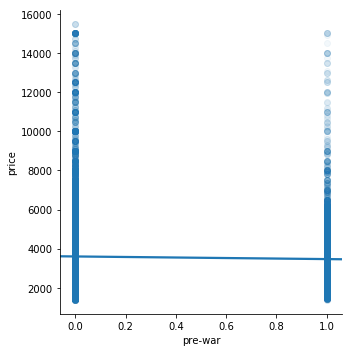

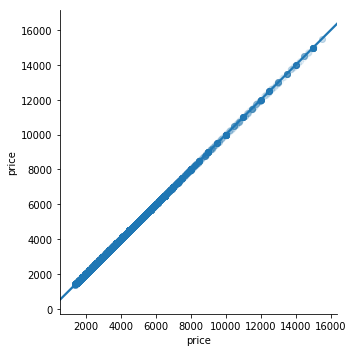

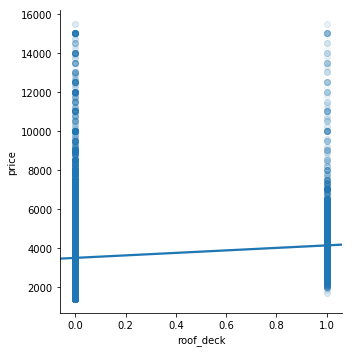

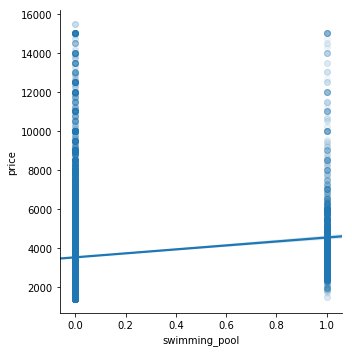

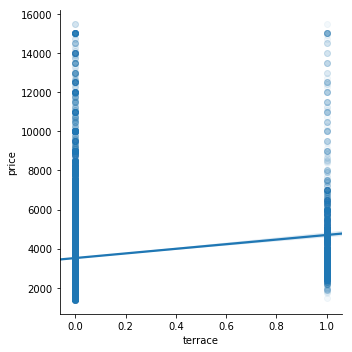

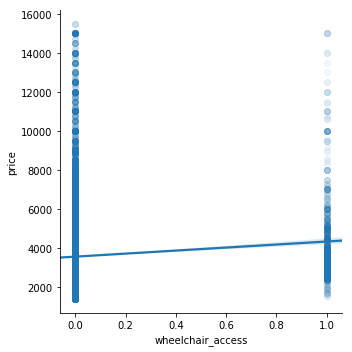

In [85]:
# Numeric features
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
  sns.lmplot(x=col, y='price', data=train, scatter_kws = dict(alpha=0.05))
  plt.show()

## Exploratory visualization for predictive modeling

Visualize the relationships between feature(s) and target.

_Recommendations:_

Do this with your training set, after splitting your data. 

Try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

Try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. 

Seaborn is nice because it includes confidence intervals to visualize uncertainty.

In [0]:
# See above

## Feature Engineering

In [92]:
def engineer_features(df):
    # What's the neighborhood, based on address or latitude & longitude?
    clusters = pd.get_dummies(df['cluster'], prefix='cluster')
    for col in clusters:
        df[col] = clusters[col]
        
    # Does the apartment have a description?
    df['description'] = df['description'].str.strip().fillna('')
    df['has_description'] = df['description'] != ''

    # How long is the description?
    df['description_length'] = df['description'].str.len()

    # How many total perks does each apartment have?
    perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
                 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
                 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
                 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
                 'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
                 'loft', 'garden_patio', 'common_outdoor_space', 
                 'wheelchair_access']
    df['perk_count'] = df[perk_cols].sum(axis=1)

    # Are cats or dogs allowed?
    df['cats_or_dogs'] = (df['cats_allowed']==1) | (df['dogs_allowed']==1)

    # Are cats and dogs allowed?
    df['cats_and_dogs'] = (df['cats_allowed']==1) & (df['dogs_allowed']==1)

    # Total number of rooms (beds + baths)
    df['rooms'] = df['bedrooms'] + df['bathrooms']

    return df

    
train = engineer_features(train)
test = engineer_features(test)
train.shape, test.shape

((31844, 51), (16973, 51))

## Feature Selection

The previous assignment quoted Wikipedia on [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering):

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

Pedro Domingos says, "the most important factor is the **features used**."

This includes not just **Feature Engineering** (making new features, representing features in new ways) but also **Feature Selection** (choosing which features to include and which to exclude).

There are _many_ specific tools and techniques for feature selection.

- Today we'll try [scikit-learn's `SelectKBest` transformer](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection), for "univariate, forward selection."
- Next week we'll try another technique, ["permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
- If you want to explore even more options, here are some good resources!
  - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
  - [mlxtend](http://rasbt.github.io/mlxtend/) library
  - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
  - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.


My general recommendation is:

> Predictive accuracy on test sets is the criterion for how good the model is. — Leo Breiman, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)

### Can we try every possible feature combination?
- https://en.wikipedia.org/wiki/Combination
- https://docs.python.org/3/library/itertools.html#itertools.combinations
- https://docs.python.org/3/library/math.html#math.factorial

In [93]:
# How many features do we have currently?
target = 'price'
features = train.columns.drop(target)
len(features)

50

In [94]:
# How many ways to choose 1 feature?
from itertools import combinations
len(list(combinations(features, 1)))

50

In [95]:
# How many ways to choose 2 features?
len(list(combinations(features, 2)))

1225

In [96]:
# How many ways to choose 3 features?
len(list(combinations(features, 3)))

19600

In [97]:
# How many ways to choose 1 to n features?

from math import factorial

def n_choose_k(n, k):
    return factorial(n)/(factorial(k)*factorial(n-k))

total = 0
for k in range(1, len(features)+1):
    total += n_choose_k(len(features), k)
    
print(f'{total:,}')

1,125,899,906,842,623.0


### Start simple & fast, with a subset of columns

Just numeric columns with no missing values

In [102]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

target = 'price'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test = test_subset[features]
y_test = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31844, 42), (31844,), (16973, 42), (16973,))

### Univariate, Forward selection
https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

In [103]:
# Select the 10 features that best correlate to the target
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((31844, 10), (16973, 10))

In [106]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
selected_names

print('Features selected:')
for name in selected_names:
  print(name)

Features selected:
bathrooms
bedrooms
longitude
doorman
dishwasher
fitness_center
laundry_in_unit
dining_room
perk_count
rooms


In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:.0f}')

Test MAE: $713


In [110]:
import statsmodels.api as sm
X1 = sm.add_constant(X_train_selected)
result = sm.OLS(y_train, X1).fit()
print(result.rsquared, result.rsquared_adj)

0.605125896301451 0.6050142588404568


In [112]:
for k in range(1, len(X_train.columns)+1):
  print(f'{k} features')
  
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)
  
  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)
  
  mae = mean_absolute_error(y_test, y_pred)
  print (mae, '\n')
  

1 features
890.4611966931298 

2 features
825.8987822403526 

3 features
825.8718486673952 

4 features
799.7255651627421 

5 features
800.1639812465511 

6 features
772.6567164483739 

7 features
713.0776598713633 

8 features
713.4626823925811 

9 features
713.4477001767991 

10 features
712.9345954980721 

11 features
710.798120604021 

12 features
698.1654649605229 

13 features
698.1914107808395 

14 features
680.2788965369637 

15 features
679.8908769896293 

16 features
679.8200076443125 

17 features
679.4301198848466 

18 features
679.3900263299467 

19 features
679.4018876824629 

20 features
677.6803769255009 

21 features
677.819237083867 

22 features
670.9720372398378 

23 features
665.492565433437 

24 features
662.4688187102846 

25 features
662.5594793919495 

26 features
660.2182282120881 

27 features
660.2984695939961 

28 features
660.0752204846192 

29 features
659.7493483468436 

30 features
658.8023623501839 

31 features
658.8230578117693 

32 features
659.5024

## Do one-hot encoding of categorical features

### Which features are non-numeric?

### Check "cardinality" of non-numeric features

[Cardinality](https://simple.wikipedia.org/wiki/Cardinality) means the number of unique values that a feature has:
> In mathematics, the cardinality of a set means the number of its elements. For example, the set A = {2, 4, 6} contains 3 elements, and therefore A has a cardinality of 3. 

"One-hot encoding" adds a dimension for each unique value of each categorical feature. So, it may not be a good choice for "high cardinality" categoricals that have dozens, hundreds, or thousands of unique values. 

### Explore `interest_level` feature

### Encode `interest_level` feature

## Do one-hot encoding & Scale features, 
within a complete model fitting workflow.

### Why and how to scale features before fitting linear models

Scikit-Learn User Guide, [Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html)
> Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

> The `preprocessing` module further provides a utility class `StandardScaler` that implements the `Transformer` API to compute the mean and standard deviation on a training set. The scaler instance can then be used on new data to transform it the same way it did on the training set.

### How to use encoders and scalers in scikit-learn
- Use the **`fit_transform`** method on the **train** set
- Use the **`transform`** method on the **validation / test** sets